In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
# Step 1: Load the dataset
data = pd.read_csv('understat_per_game.csv')

In [3]:
# Step 2: Handle outliers in the target variable ('scored') using the IQR method
Q1 = data['scored'].quantile(0.25)
Q3 = data['scored'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['scored'] >= lower_bound) & (data['scored'] <= upper_bound)]

print(f"Dataset shape after removing outliers: {data.shape}")

Dataset shape after removing outliers: (24420, 29)


In [4]:
# Step 3: Drop high-correlation features and non-useful columns
high_corr_features = ['pts', 'npxG', 'npxGD', 'xG', 'xG_diff', 'wins', 'npxG', 
                      'xpts', 'xGA_diff', 'xGA', 'npxGA', 'xpts_diff', 'loses', 'draws']
data = data.drop(columns=high_corr_features + ['result', 'date', 'team', "year"])

In [5]:
# Step 4: Feature Engineering
data['ppda_efficiency'] = data['ppda_att'] / (data['ppda_def'] + 1)
data['oppda_efficiency'] = data['oppda_att'] / (data['oppda_def'] + 1)
data['relative_ppda_efficiency'] = data['ppda_efficiency'] / (data['oppda_efficiency'] + 1)
data['ppda_intensity'] = data['ppda_coef'] * data['ppda_att']
data['oppda_intensity'] = data['oppda_coef'] * data['oppda_att']
data['intensity_diff'] = data['ppda_intensity'] - data['oppda_intensity']

# Add interaction features
data['deep_x_ppda_intensity'] = data['deep'] * data['ppda_intensity']
data['deep_x_oppda_intensity'] = data['deep'] * data['oppda_intensity']
data['deep_x_intensity_diff'] = data['deep'] * data['intensity_diff']

# Add polynomial features for 'deep' and 'intensity_diff'
data['deep_squared'] = data['deep'] ** 2
data['deep_cubed'] = data['deep'] ** 3
data['intensity_diff_squared'] = data['intensity_diff'] ** 2
data['intensity_diff_cubed'] = data['intensity_diff'] ** 3

In [6]:
# Apply one-hot encoding to categorical columns ('h_a')
data = pd.get_dummies(data, columns=['h_a', 'league'], drop_first=True)

In [7]:
# Step 5: Define target and features
X = data.drop(columns=['scored'])  # Features
y = data['scored']  # Target variable (actual goals scored)

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Step 7: Initialize and train the XGBoost Regressor with best hyperparameters
xgb_model = xgb.XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=100,
    reg_alpha=1,
    reg_lambda=1,
    subsample=0.8,
    random_state=42,
    objective='reg:squarederror'
)

# Step 8: Cross-validation
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

cv_results = cross_validate(xgb_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Display Cross-Validation Results
print("\nCross-Validation Results:")
mae_scores = -cv_results['test_MAE']  # Convert negative MAE to positive
print(f"MAE Scores for Each Fold: {mae_scores}")
print(f"Mean MAE: {mae_scores.mean():.4f}")
print(f"Standard Deviation of MAE: {mae_scores.std():.4f}")
print(f"Mean MSE: {-np.mean(cv_results['test_MSE']):.4f}")
print(f"Mean R-squared (R²): {np.mean(cv_results['test_R2']):.4f}")


Cross-Validation Results:
MAE Scores for Each Fold: [0.86996701 0.89215174 0.86990874 0.86164468 0.87288513]
Mean MAE: 0.8733
Standard Deviation of MAE: 0.0101
Mean MSE: 1.2046
Mean R-squared (R²): 0.1286


In [9]:
# Step 9: Train the model on the full training set
xgb_model.fit(X_train, y_train)

# Step 10: Evaluate the model on the test set
y_pred_xgb_test = xgb_model.predict(X_test)
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb_test)
mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb_test)
r2_xgb_test = r2_score(y_test, y_pred_xgb_test)

print("\nOptimized XGBoost Model Test Set Performance (With Enhanced Features):")
print(f"Mean Absolute Error (MAE): {mae_xgb_test}")
print(f"Mean Squared Error (MSE): {mse_xgb_test}")
print(f"R-squared (R2): {r2_xgb_test}")


Optimized XGBoost Model Test Set Performance (With Enhanced Features):
Mean Absolute Error (MAE): 0.8757570950309826
Mean Squared Error (MSE): 1.202495955086191
R-squared (R2): 0.13157205520389825



Feature Importances based on Optimized XGBoost Model:
                     Feature  Importance
18              deep_squared    0.195946
0                       deep    0.120664
22                     h_a_h    0.067902
7                  oppda_att    0.047444
19                deep_cubed    0.043811
16    deep_x_oppda_intensity    0.037627
15     deep_x_ppda_intensity    0.035357
26               league_RFPL    0.032994
2                     missed    0.029298
12            ppda_intensity    0.028165
4                   ppda_att    0.028138
17     deep_x_intensity_diff    0.025242
21      intensity_diff_cubed    0.023791
9            ppda_efficiency    0.021597
20    intensity_diff_squared    0.021580
14            intensity_diff    0.021413
13           oppda_intensity    0.021179
10          oppda_efficiency    0.020622
11  relative_ppda_efficiency    0.019629
8                  oppda_def    0.019423
5                   ppda_def    0.018919
23                league_EPL    0.018120
6 

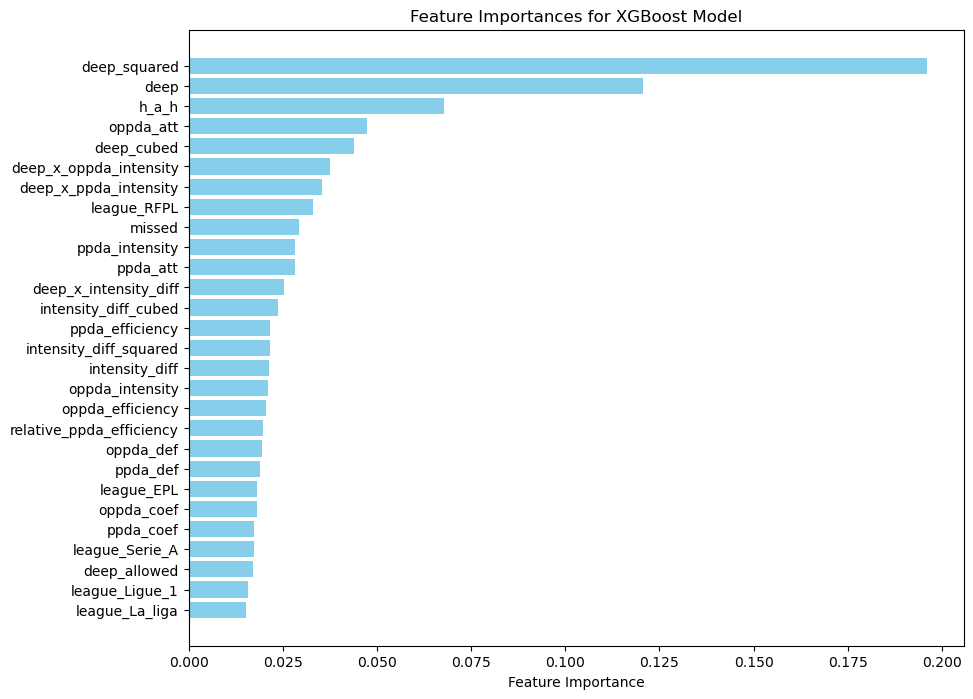

In [10]:
# Step 11: Display feature importances
importances = xgb_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances based on Optimized XGBoost Model:")
print(feature_importances)

# Step 12: Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances for XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

### RESIDUAL PLOT

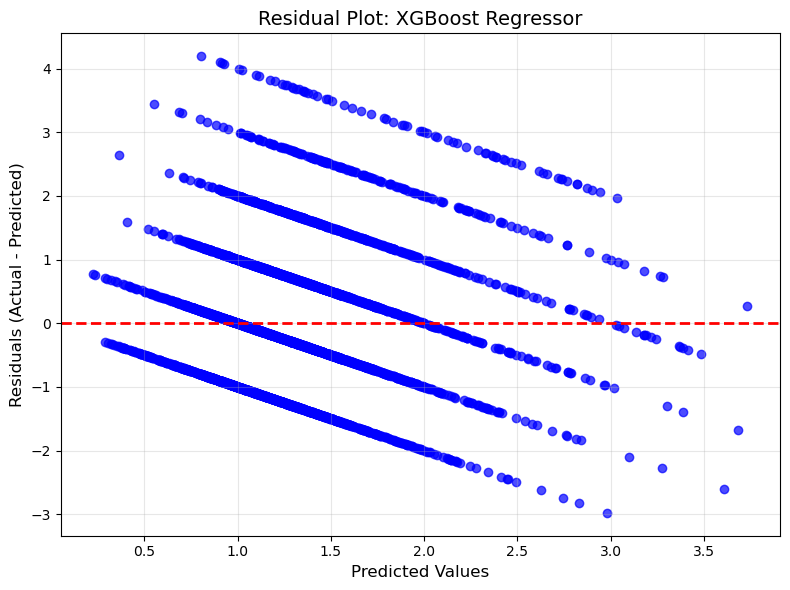

In [11]:
# Residual Plot
residuals_xgb = y_test - y_pred_xgb_test

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb_test, residuals_xgb, alpha=0.7, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot: XGBoost Regressor', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("xgboost_residual_plot.png")
plt.show()

### Predicted vs Actual Goals

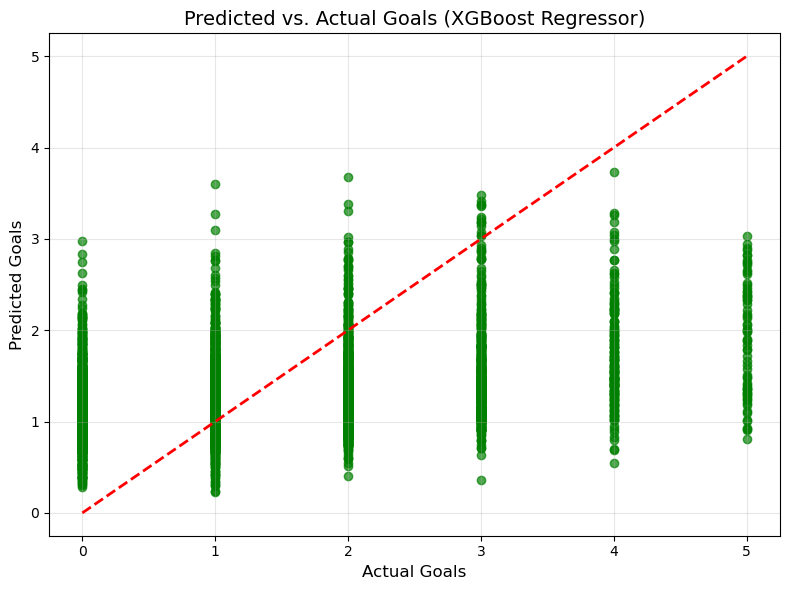

In [12]:
# Predicted vs. Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb_test, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.title('Predicted vs. Actual Goals (XGBoost Regressor)', fontsize=14)
plt.xlabel('Actual Goals', fontsize=12)
plt.ylabel('Predicted Goals', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("xgboost_predicted_vs_actual.png")
plt.show()

### Error Breakdown by Goal Ranges


Error Breakdown by Goal Ranges:
  Goal Range  Mean Absolute Error
0        0-1             1.141001
1        1-2             0.333697
2        2-3             0.695091
3         3+             1.687780


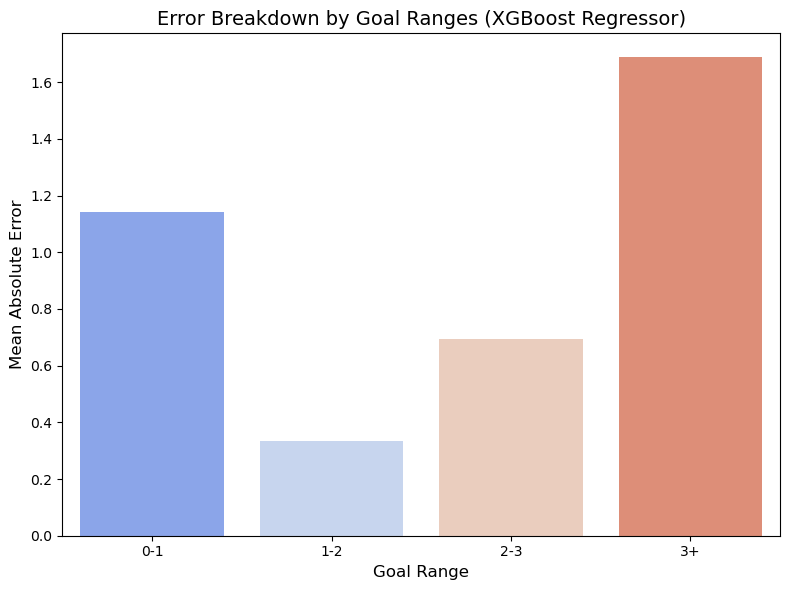

In [13]:
# Import necessary library for visualization
import seaborn as sns

# Error Breakdown by Goal Ranges
residuals = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_xgb_test,
    'Residual': y_test - y_pred_xgb_test
})

# Define goal ranges (bins) for analysis
goal_bins = [0, 1, 2, 3, 5]  # Define ranges: 0-1, 1-2, etc.
residuals['Goal Range'] = pd.cut(residuals['Actual'], bins=goal_bins, right=False, labels=['0-1', '1-2', '2-3', '3+'])

# Calculate mean absolute error (MAE) for each goal range
error_by_range = residuals.groupby('Goal Range').apply(lambda x: np.mean(np.abs(x['Residual']))).reset_index()
error_by_range.columns = ['Goal Range', 'Mean Absolute Error']

# Print the error breakdown
print("\nError Breakdown by Goal Ranges:")
print(error_by_range)

# Bar Plot for Error Breakdown
plt.figure(figsize=(8, 6))
sns.barplot(data=error_by_range, x='Goal Range', y='Mean Absolute Error', palette='coolwarm')
plt.title('Error Breakdown by Goal Ranges (XGBoost Regressor)', fontsize=14)
plt.xlabel('Goal Range', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.tight_layout()
plt.savefig("xgboost_error_breakdown_by_goal_ranges.png")
plt.show()

### Metrics by goal ranges


Subset Metrics by Goal Range:
Goal Range: 0-1
  Mean Absolute Error (MAE): 1.1410
  Mean Squared Error (MSE): 1.4227
  R-squared (R²): 0.0000

Goal Range: 2-3
  Mean Absolute Error (MAE): 0.4753
  Mean Squared Error (MSE): 0.3485
  R-squared (R²): -0.4627

Goal Range: 3+
  Mean Absolute Error (MAE): 1.8172
  Mean Squared Error (MSE): 3.8299
  R-squared (R²): -7.9994


Subset Metrics by Home/Away Games:
Home Games:
  Mean Absolute Error (MAE): 0.9324
  Mean Squared Error (MSE): 1.3394
  R-squared (R²): 0.1094

Away Games:
  Mean Absolute Error (MAE): 0.8210
  Mean Squared Error (MSE): 1.0700
  R-squared (R²): 0.1133


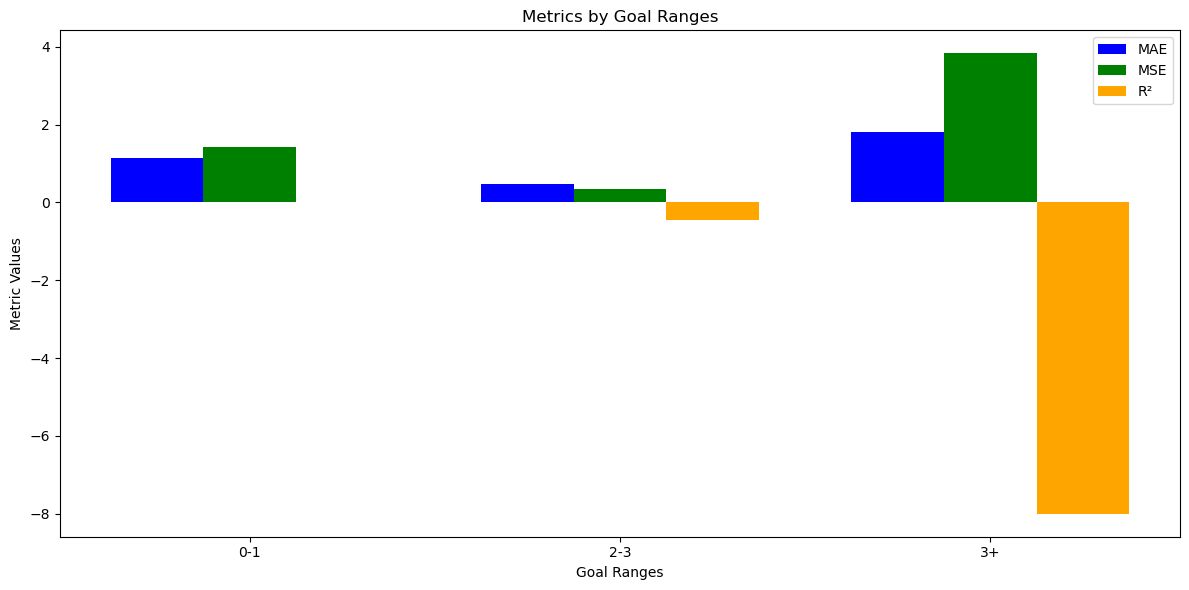

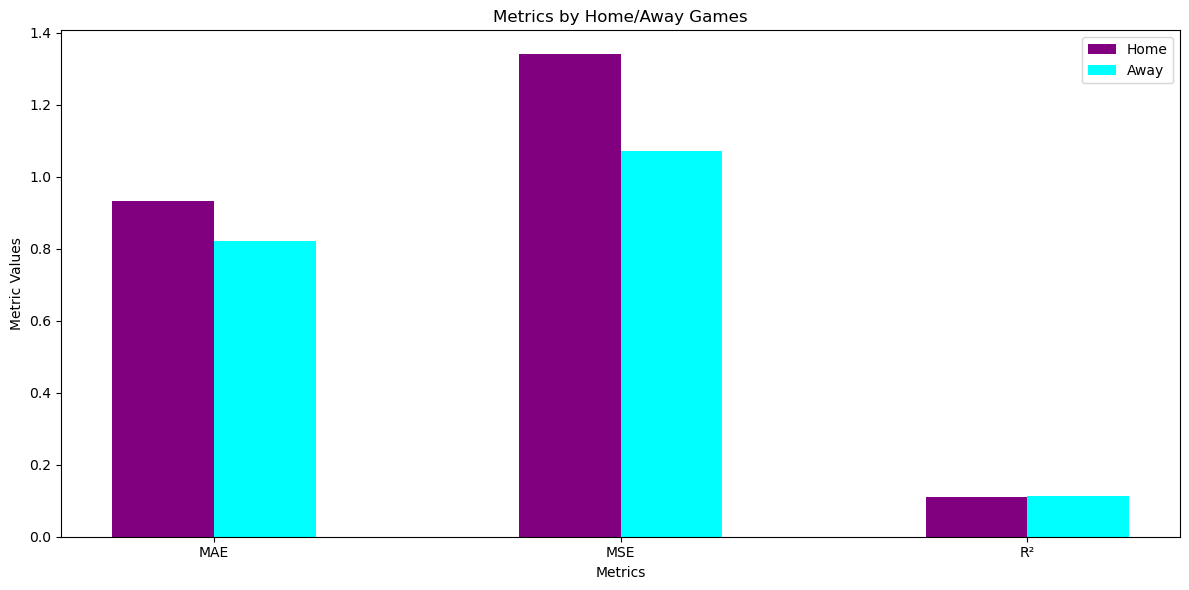

In [14]:
# Subset Metrics Calculation

# Step 1: Define goal ranges for analysis (use y_test directly for test set metrics)
goal_bins = [0, 1, 3, float('inf')]  # Ranges: 0-1, 2-3, 3+
goal_labels = ['0-1', '2-3', '3+']
goal_ranges = pd.cut(y_test, bins=goal_bins, labels=goal_labels, right=False)  # Only for the test set

# Step 2: Calculate metrics for each goal range
print("\nSubset Metrics by Goal Range:")
for goal_range in goal_labels:
    subset_indices = goal_ranges == goal_range  # Indexing directly on test set
    y_actual = y_test[subset_indices]
    y_predicted = y_pred_xgb_test[subset_indices]
    
    mae = mean_absolute_error(y_actual, y_predicted)
    mse = mean_squared_error(y_actual, y_predicted)
    r2 = r2_score(y_actual, y_predicted)
    
    print(f"Goal Range: {goal_range}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    print()

# Step 3: Calculate metrics for home vs. away games (based on test set features)
home_indices = X_test['h_a_h'] == 1  # Home games
away_indices = X_test['h_a_h'] == 0  # Away games

print("\nSubset Metrics by Home/Away Games:")

# Home games
mae_home = mean_absolute_error(y_test[home_indices], y_pred_xgb_test[home_indices])
mse_home = mean_squared_error(y_test[home_indices], y_pred_xgb_test[home_indices])
r2_home = r2_score(y_test[home_indices], y_pred_xgb_test[home_indices])

print("Home Games:")
print(f"  Mean Absolute Error (MAE): {mae_home:.4f}")
print(f"  Mean Squared Error (MSE): {mse_home:.4f}")
print(f"  R-squared (R²): {r2_home:.4f}")
print()

# Away games
mae_away = mean_absolute_error(y_test[away_indices], y_pred_xgb_test[away_indices])
mse_away = mean_squared_error(y_test[away_indices], y_pred_xgb_test[away_indices])
r2_away = r2_score(y_test[away_indices], y_pred_xgb_test[away_indices])

print("Away Games:")
print(f"  Mean Absolute Error (MAE): {mae_away:.4f}")
print(f"  Mean Squared Error (MSE): {mse_away:.4f}")
print(f"  R-squared (R²): {r2_away:.4f}")

# Calculate Subset Metrics for Goal Ranges
mae_0_1 = mean_absolute_error(y_test[goal_ranges == '0-1'], y_pred_xgb_test[goal_ranges == '0-1'])
mse_0_1 = mean_squared_error(y_test[goal_ranges == '0-1'], y_pred_xgb_test[goal_ranges == '0-1'])
r2_0_1 = r2_score(y_test[goal_ranges == '0-1'], y_pred_xgb_test[goal_ranges == '0-1'])

mae_2_3 = mean_absolute_error(y_test[goal_ranges == '2-3'], y_pred_xgb_test[goal_ranges == '2-3'])
mse_2_3 = mean_squared_error(y_test[goal_ranges == '2-3'], y_pred_xgb_test[goal_ranges == '2-3'])
r2_2_3 = r2_score(y_test[goal_ranges == '2-3'], y_pred_xgb_test[goal_ranges == '2-3'])

mae_3_plus = mean_absolute_error(y_test[goal_ranges == '3+'], y_pred_xgb_test[goal_ranges == '3+'])
mse_3_plus = mean_squared_error(y_test[goal_ranges == '3+'], y_pred_xgb_test[goal_ranges == '3+'])
r2_3_plus = r2_score(y_test[goal_ranges == '3+'], y_pred_xgb_test[goal_ranges == '3+'])

# Subset Metrics Data for Goal Ranges
goal_ranges = ['0-1', '2-3', '3+']
goal_mae = [mae_0_1, mae_2_3, mae_3_plus]
goal_mse = [mse_0_1, mse_2_3, mse_3_plus]
goal_r2 = [r2_0_1, r2_2_3, r2_3_plus]

# Plot for Goal Ranges Metrics
plt.figure(figsize=(12, 6))
x = np.arange(len(goal_ranges))
width = 0.25

plt.bar(x - width, goal_mae, width=width, label='MAE', color='blue')
plt.bar(x, goal_mse, width=width, label='MSE', color='green')
plt.bar(x + width, goal_r2, width=width, label='R²', color='orange')

plt.xticks(x, goal_ranges)
plt.xlabel('Goal Ranges')
plt.ylabel('Metric Values')
plt.title('Metrics by Goal Ranges')
plt.legend()
plt.tight_layout()
plt.show()

# Subset Metrics Data for Home/Away Games
categories = ['Home', 'Away']
home_metrics = [mae_home, mse_home, r2_home]
away_metrics = [mae_away, mse_away, r2_away]
metrics = ['MAE', 'MSE', 'R²']

# Plot for Home/Away Games Metrics
plt.figure(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width / 2, home_metrics, width=width, label='Home', color='purple')
plt.bar(x + width / 2, away_metrics, width=width, label='Away', color='cyan')

plt.xticks(x, metrics)
plt.xlabel('Metrics')
plt.ylabel('Metric Values')
plt.title('Metrics by Home/Away Games')
plt.legend()
plt.tight_layout()
plt.show()

100%|===================| 4864/4884 [00:20<00:00]        

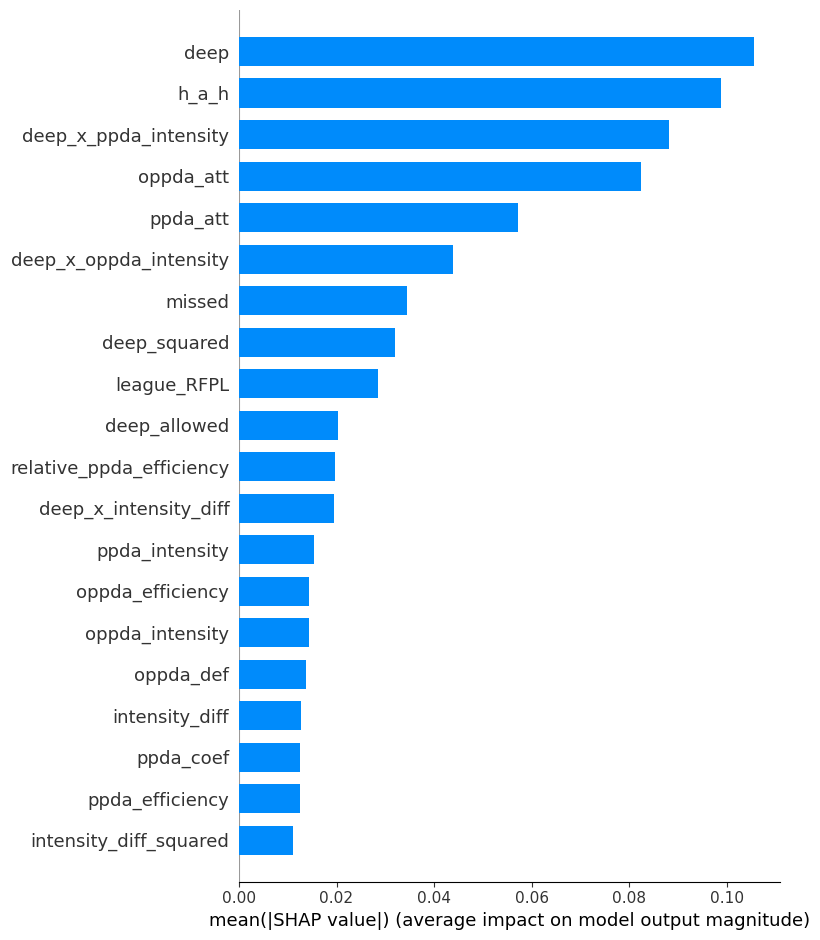

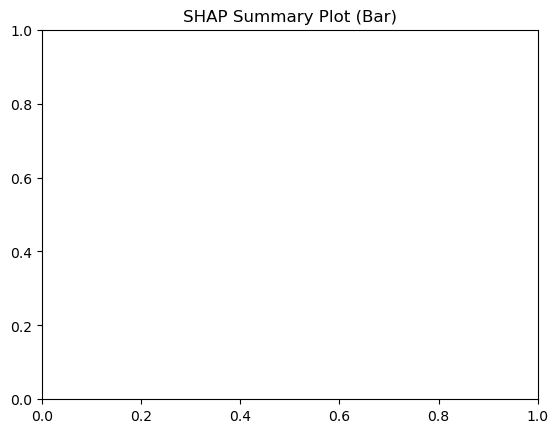

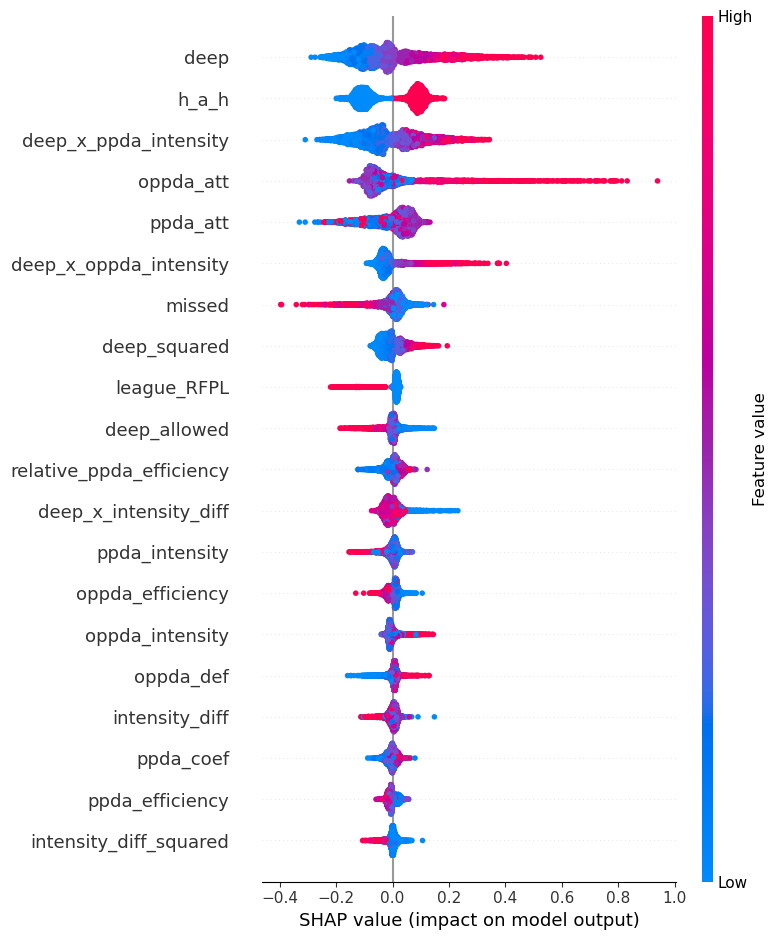

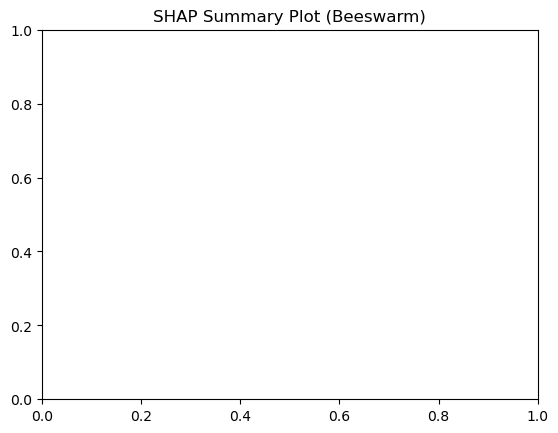

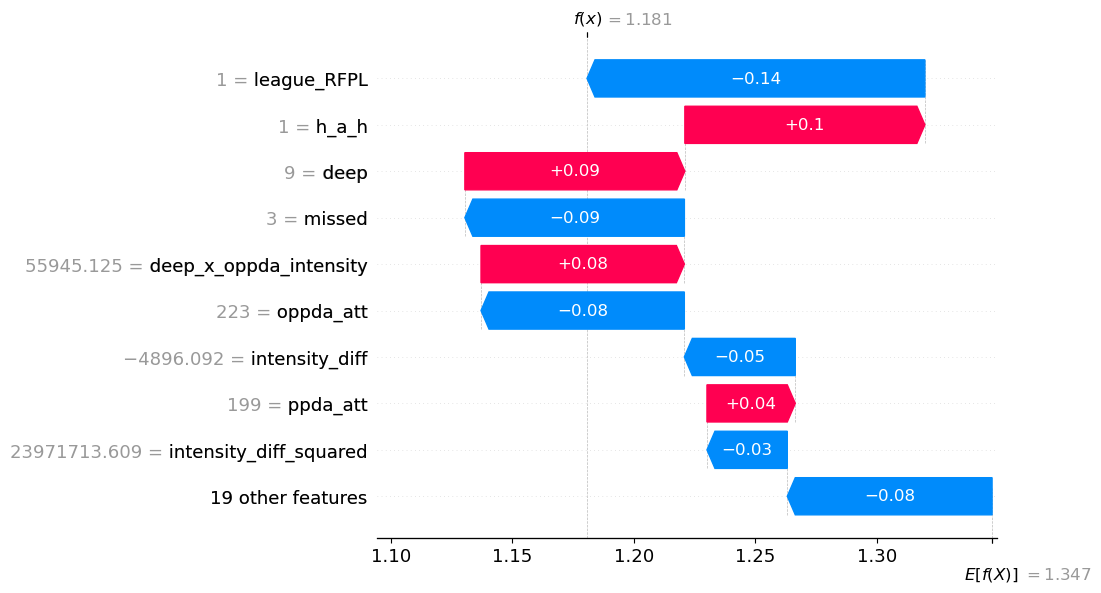

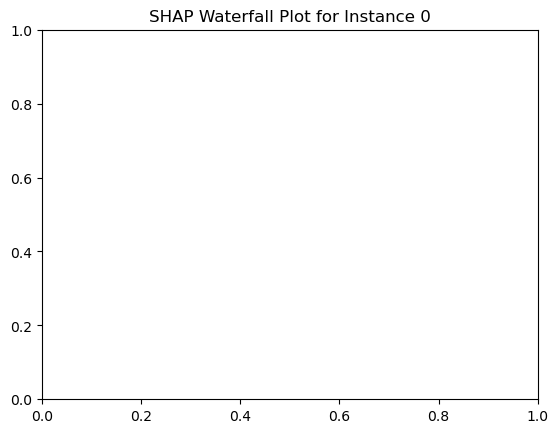

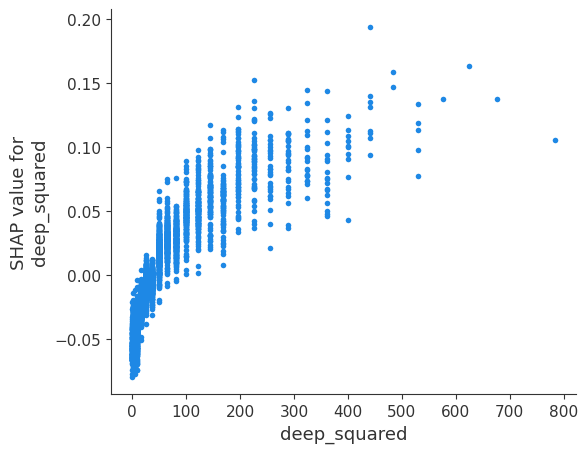

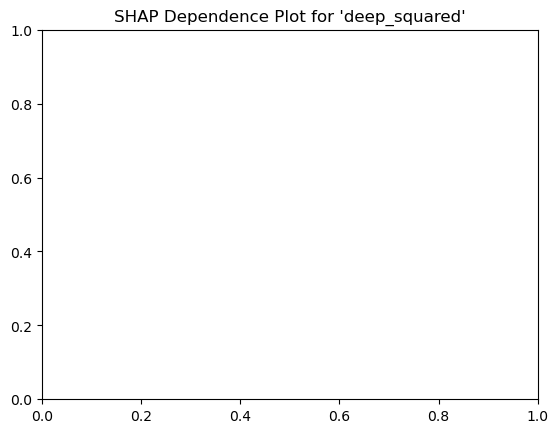

In [18]:
# Step 1: Initialize the SHAP explainer
explainer = shap.Explainer(xgb_model, X_train)

# Step 2: Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Step 3: Visualize SHAP summary plot for feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
plt.title("SHAP Summary Plot (Bar)")
plt.show()

# Step 4: Detailed SHAP summary plot (beeswarm plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.show()

# Step 5: Analyze SHAP values for a specific instance
instance_index = 0  # Replace with any specific row index from the test set
shap.waterfall_plot(shap_values[instance_index])  # Use only shap_values[instance_index] without X_test row
plt.title(f"SHAP Waterfall Plot for Instance {instance_index}")
plt.show()

# Step 6: Dependence plot for a specific feature (e.g., 'deep_squared')
shap.dependence_plot("deep_squared", shap_values.values, X_test, interaction_index=None)
plt.title("SHAP Dependence Plot for 'deep_squared'")
plt.show()
